<a href="https://colab.research.google.com/github/Madelinelai/SideProject/blob/main/SP_houseprice_data_clean_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **資料分析與資料清理**

1. 資料清理
1. 缺值的處理
1. 極端值的處理
1. 資料分析
  1. 數值資料
  1. 類別資料
  1. 時間序列資料
1. 畫出台北市房價分佈圖  

In [ ]:
# 套件安裝 (避免未來 Colab 預設使用新版本 Python 套件造成程式無法執行)
!pip install arrow==0.15.5
!pip install matplotlib==3.2.1
!pip install PyDrive==1.3.1
!pip install -U git+https://github.com/lintseju/gmplot

     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 12.4MB 307kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


  Cloning https://github.com/lintseju/gmplot to /tmp/pip-req-build-xzmbk4_k
  Running command git clone -q https://github.com/lintseju/gmplot /tmp/pip-req-build-xzmbk4_k
  Created wheel for gmplot: filename=gmplot-1.2.0-cp36-none-any.whl size=146559 sha256=7698f74ceaa549bcdde432c0a5fa28144e242ed765c7f3a072ddabf78526e909
  Stored in directory: /tmp/pip-ephem-wheel-cache-pst0orza/wheels/13/fb/40/0a061669426308988a1291c06f4a4978a1a5383087b2438b85
Successfully built gmplot


In [ ]:
import arrow
import glob
import gmplot
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# 下載房價資料

if not os.path.exists('house_price.zip'):
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    file_id = '1QOaz8sqVyZzvjikzUzUfpcEiyBKi9-dE'
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile('house_price.zip')
# Taiwan address data: https://github.com/zhengda/taiwan-address-data
if not os.path.exists('taiwan-address-data.zip'):
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    file_id = '1JFBIaoq6VyV5P4pgE-ug3lljgjI8Olht'
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile('taiwan-address-data.zip')
!unzip house_price.zip
!unzip -qq taiwan-address-data.zip
!ls taiwan-address-data

Archive:  house_price.zip
   creating: house_price/
  inflating: house_price/107S3_A_lvr_land_A.csv  
  inflating: house_price/107S4_A_lvr_land_A.csv  
  inflating: house_price/108S1_A_lvr_land_A.csv  
  inflating: house_price/108S2_A_lvr_land_A.csv  
  inflating: house_price/108S3_A_lvr_land_A.csv  
  inflating: house_price/108S4_A_lvr_land_A.csv  
  inflating: house_price/109S1_A_lvr_land_A.csv  
address.html  area_1984.csv  area_2014.csv    README.md  roads
address.js    area_2010.csv  area_custom.csv  road.csv


# **什麼是資料清理 (data cleaning)**

今天有一個欄位是使用者戶籍地址...

你想像上會是：台北市南海路56號1樓

看到的可能會是...

台北市南海路56號一樓

台北市南海路五六號一樓

台北市南海路伍拾陸號壹樓

北市南海路5566號1F

台北市信義區南海路五十六號一樓 (其實是中正區)

最後發現...台北市南海路56號，其實是台北市某公立高中的地址

但是，戶籍好像真的可以放學校 [台北市政府 FAQ](https://www.gov.taipei/News_Content.aspx?n=EEC70A4186D4C828&sms=87415A8B9CE81B16&s=1F67300FE16160E5)：(戶籍)遷入工廠、商店、寺廟、機關、學校、其他公共處所者，憑戶長或主持人或管理人之同意書辦理。

**資料清理：使每筆資料皆符合之後分析與模型訓練所假設的格式。**

# **乾淨的資料 > 複雜厲害的模型**


 Data cleaning 流程：

1.   觀察資料
1.   訂出資料的格式
     1. schema 包含 型態、數值範圍、是否允許空值、是否唯一...
     1. 資料是否正確 (ex. 地址確實存在)
     1. 統一的單位
     1. 其他欄位的關係是否一致
1.   檢查資料是否符合 schema 以及 outlier
1.   有無重覆資料或缺值
1.   手動或使用程式修正資料 (ex. address.replace('一', '1'))
1.   重複 1 -> 5

注意：資料有分數值資料(numerical data)與類別資料(categorical data)



# **缺值(missing value)的處理**

1. 丟掉有缺值的資料
  1. 缺值很少且是隨機的：丟掉該筆資料
  1. 缺值很多且是隨機的：該欄位
1. 「猜」原本是多少
  1. 使用統計值填補 (ex. mean, median)，其中 mean 對極端值比較敏感
  1. 根據其他維度的值填補，假設其他欄位一樣則此欄位也會一樣。
  1. 用其他欄位的值做 feature，訓練一個模型預測這個欄位的值
1. Flag：多一個維度 (見下方程式碼) 或是多一個類別
  1. 填上去的值計算時必須忽略


In [ ]:
np.random.seed(551335114)
x = np.random.random((20, 3))
for i in range(x.shape[0]):
    # 60% 缺值
    if np.random.random(1) < 0.6:
        x[i, 2] = np.nan
print('原本的資料\n', x)

x = np.hstack([x, np.zeros((x.shape[0], 1))])
x[np.where(np.isnan(x[:, 2])), 3] = 1
x = np.nan_to_num(x)
print('新的 feature\n', x)

原本的資料
 [[0.37506215 0.57845968        nan]
 [0.42041723 0.39131574        nan]
 [0.05672291 0.42837034 0.84109867]
 [0.02630694 0.36045944 0.37006891]
 [0.93000512 0.74395577        nan]
 [0.34533525 0.06382192 0.53780582]
 [0.2716344  0.02020441 0.71508673]
 [0.5137723  0.73493963 0.56843638]
 [0.66601894 0.03830729        nan]
 [0.04945224 0.46014967        nan]
 [0.58101402 0.41698561        nan]
 [0.85449629 0.18153084        nan]
 [0.98573643 0.70899003        nan]
 [0.32822343 0.28107521        nan]
 [0.52853248 0.70343989        nan]
 [0.91454837 0.51185731        nan]
 [0.37535868 0.25944971 0.35613474]
 [0.80885526 0.71766686 0.5304037 ]
 [0.38066098 0.89955846 0.04790545]
 [0.4438881  0.73300687        nan]]
新的 feature
 [[0.37506215 0.57845968 0.         1.        ]
 [0.42041723 0.39131574 0.         1.        ]
 [0.05672291 0.42837034 0.84109867 0.        ]
 [0.02630694 0.36045944 0.37006891 0.        ]
 [0.93000512 0.74395577 0.         1.        ]
 [0.34533525 0.06382192 0

# **極端值 (outlier) 的處理**

什麼是極端值？

年齡：[5, 30, 28, 84, 1, 65, 40, ***1000***, 12, 25, 24]

需要一個數學定義！


In [ ]:
# randn: random floats sampled from a univariate “normal” (Gaussian) distribution of mean 0 and variance 1
# randn: 從平均 0 variance 1 的常態分佈隨機抽出浮點數
data = np.random.randn(10000) * 100 + 100
print(data)

# 移除三倍標準差外的資料 (當 n_str=3)
def remove_outlier_gaussian(data, n_std=3):
    mean = np.mean(data)
    std = np.std(data)
    outlier = data[np.logical_or(data <= mean - std * n_std, data >= mean + std * n_std)]
    cleaned_data = data[np.logical_and(data > mean - std * n_std, data < mean + std * n_std)]
    return cleaned_data, outlier

print('Shape before remove outlier', data.shape)
cleaned_data, outlier = remove_outlier_gaussian(data)
print('Shape after remove outlier', cleaned_data.shape)  # should be near to 99.7% for gaussian
print(outlier)

# IQR: interquartile range 四分位距
# 移除 1.5xIQR 外的資料
def remove_outlier_iqr(data, n_iqr=1.5):
    q1, q3 = np.percentile(data, (25, 75))
    iqr = q3 - q1
    outlier = data[np.logical_or(data <= q1 - n_iqr * iqr, data >= q3 + n_iqr * iqr)]
    cleaned_data = data[np.logical_and(data > q1 - n_iqr * iqr, data < q3 + n_iqr * iqr)]
    return cleaned_data, outlier

print('Shape before remove outlier', data.shape)
cleaned_data, outlier = remove_outlier_iqr(data)
print('Shape after remove outlier', cleaned_data.shape)
print(outlier)


[226.88280324  52.75008145  33.32277931 ...  86.79913365 262.69351887
  85.25173642]
Shape before remove outlier (10000,)
Shape after remove outlier (9974,)
[-276.73754856  406.56243738 -224.43853484 -207.93553558 -205.47329341
  410.02339908  420.67211612  415.34274394  454.75900005 -208.54895339
  417.12102761 -276.05913459  415.6261839   453.67563198 -207.40124577
 -239.53044873 -217.61570076 -212.92492384  423.81427378 -221.55519232
 -308.47090691  411.59983978 -208.1498327  -234.74374545  470.63589682
  432.84735952]
Shape before remove outlier (10000,)
Shape after remove outlier (9942,)
[ 382.342815   -276.73754856 -172.00786918  406.56243738 -193.67330017
  392.51699481  380.59523413 -191.15627599 -197.00705039 -224.43853484
 -207.93553558 -185.49013963  378.56843625 -205.47329341  410.02339908
  379.70051175  385.99051973 -188.06964225  420.67211612  415.34274394
  454.75900005 -188.64832006 -208.54895339  417.12102761 -276.05913459
  374.74999032  415.6261839   374.74286547  4

注意：沒有必要的話不要刪除極端值

什麼是必要？

1. 明顯有錯(ex. 年齡 = 1000)
1. 模型對極端值敏感(ex. linear regression 系列)

In [ ]:
# Pandas: Python 處理資料的好幫手
import pandas as pd

for path in glob.iglob('house_price/*.csv'):
    df = pd.read_csv(path)
    break
print(df)

                                       鄉鎮市區  ...                   編號
0     The villages and towns urban district  ...        serial number
1                                       文山區  ...  RPUNMLNKQHNFFAA18CA
2                                       文山區  ...  RPQNMLOKQHNFFAA87CA
3                                       文山區  ...  RPSOMLOKQHNFFAA18CA
4                                       文山區  ...  RPTNMLPKQHNFFAA28CA
...                                     ...  ...                  ...
5348                                    士林區  ...  RPUNMLMKJINFFEA97DA
5349                                    士林區  ...  RPTNMLKKJINFFEA67DA
5350                                    北投區  ...  RPPNMLKKJINFFEA27DA
5351                                    北投區  ...  RPTNMLNKJINFFEA97DA
5352                                    士林區  ...  RPOOMLLLJINFFEA47DA

[5353 rows x 28 columns]


內政部實價登錄資料下載：https://plvr.land.moi.gov.tw/DownloadOpenData

In [ ]:
# train 10707 - 10806
# validation 10807 - 10809
# test 10810 - 10812
# 讀取 training 期間的資料
label = 'the unit price (NTD / square meter)'
df = []
for path in glob.iglob('house_price/*.csv'):
    if '108S3' not in path and '108S4' not in path and '109S1' not in path:
        df.append(pd.read_csv(path, skiprows=1))
df = pd.concat(df).sort_values('transaction year month and day')
# 刪掉只有車位的交易記錄
df = df.loc[df['transaction sign'] != '車位']
# 只留下使用分區為住宅的記錄
df = df.loc[df['the use zoning or compiles and checks'] == '住']
idx = df[label].isnull()
# 把單位房價的缺值補上： 總價 / 轉移面積
print('單位房價缺值', sum(idx))
print('車位類型\n', df.loc[idx, 'the berth category'])
df.loc[idx, label] = df.loc[idx, 'total price NTD'] / df.loc[idx, 'building shifting total area']
print(len(df))
df.head(2)

單位房價缺值 3
車位類型
 366     NaN
5270    NaN
2889    NaN
Name: the berth category, dtype: object
12119


,The villages and towns urban district,transaction sign,land sector position building sector house number plate,land shifting total area square meter,the use zoning or compiles and checks,the non-metropolis land use district,non-metropolis land use,transaction year month and day,transaction pen number,shifting level,total floor number,building state,main use,main building materials,construction to complete the years,building shifting total area,Building present situation pattern - room,building present situation pattern - hall,building present situation pattern - health,building present situation pattern - compartmented,Whether there is manages the organization,total price NTD,the unit price (NTD / square meter),the berth category,berth shifting total area square meter,the berth total price NTD,the note,serial number
1832,內湖區,房地(土地+建物)+車位,臺北市內湖區內湖路一段411巷61~90號,95.96,住,NaN,NaN,1010325,土地2建物1車位6,二十四層,二十八層,住宅大樓(11層含以上有電梯),住家用,鋼骨鋼筋混凝土造,1051026.0,690.68,0,0,0,無,有,200810000,290742.0,坡道平面,0.0,0,1.預售屋買賣2.車位6位及全體區分所有權人共用4位,RPPOMLSJIINFFCA67CA
4274,內湖區,房地(土地+建物)+車位,臺北市內湖區內湖路一段411巷61~90號,95.96,住,NaN,NaN,1010406,土地2建物1車位6,二十層,二十八層,住宅大樓(11層含以上有電梯),住家用,鋼骨鋼筋混凝土造,1051026.0,690.68,0,0,0,無,無,188560000,273006.0,坡道平面,0.0,0,1.預售屋買賣2.新建房屋尚未成立管理組織3.車位6位及全體區分所有權人共用4位,RPPPMLRJQHNFFCA38CA


In [ ]:
# list here: https://ws.www.gov.tw/Download.ashx?u=LzAwMS9VcGxvYWQvRm9ybXMvRmlsZXMvMzgyMTYyMjAwQS8zODIxNjIyMDBBLUMxWi0wMDMtZm9ybXMucGRm&n=MzgyMTYyMjAwQS1DMVotMDAzLWZvcm1zLnBkZg%3D%3D

note_list = [
    '親友、員工或其他特殊關係間之交易',
    '含增建或未登記建物',
    '建商與地主合建案',
    '包含)公共設施保留地之交易',
    '畸零地或有合併使用之交易',
    '向政府機關承購之案件',
    '受債權債務影響或債務抵償之交易',
    '急買急賣',
    '有民情風俗因素之交易',
    '單獨車位交易',
    '土地及建物分次登記案件',
    '瑕疵物件之交易'
]

def rm_default_note(line):
    for note in note_list:
        line = line.replace(note, '')
    line = line.replace('。', '').replace(';', '')
    return line

df['the note'].value_counts()
for value, count in df['the note'].fillna('').map(lambda x: rm_default_note(x)).value_counts().iteritems():
    if count > 2:
        print(value, count)


##  備註欄只允許預設的 13 種或空，其它丟掉
df = df.loc[df['the note'].fillna('').map(lambda x: len(rm_default_note(x)) == 0)]

 10529
本案為預售 120
陽台外推 77
本案車位面積無法概算 47
內含獨立產權車位，未包含在棟數內 33
管理組織日後會例行籌備，目前尚未成立 31
前案土地登記收件字號： 30
共有人數2人 26
預售屋買賣 25
二親等間買賣 25
包含公共設施保留地之交易 22
本買賣土地目前被長期占用，其占用情形由買方自行排除清理 16
二親等買賣 16
內含獨立產權車位，未包含在棟數內車位面積無法概算 15
二等親買賣 15
權利人共2人 15
頂樓增建 14
車位面積無法概算 14
本案係依預售屋合約 13
權利人共二人 13
原地主找補買回 12
兩人共有 12
新建房屋尚未成立管理組織 10
權利人有兩人 10
持分買賣 9
權利人二人 9
共有人數2人本案車位面積無法概算 8
本買賣為都市更新案件預售戶，地政士僅受託買賣案件申請登記，並未代理撰擬不動產買賣契約書，本成交資訊係由客戶自行提供屬實 8
登記二人 7
預售屋、雨遮不計價 7
本案為104年9月所簽訂之預售屋 7
權利人有二人 7
登記兩人共有 6
本案成交價為105年11月29日預售價格,本案管理組織尚未成立 6
親友間之交易 6
內含獨立產權公設，未包含在棟數內 6
含頂樓增建 6
頂樓加蓋 5
1.本案為預售2.登記權利人為二人 5
一樓空地增建 5
二親等間之買賣 5
權利人共二人. 5
持分買賣,以107年土地公告現值為價格 5
親友關係間之交易 5
因地主少取建物而有多移轉部分土地持分予建主案件 5
權利人等二人 4
雨遮不計價 4
兩戶打通 4
本案格局實際為2.5衛 4
本件為毛胚屋交易 4
朋友間買賣 4
依仲介公司提供之資料登錄 4
權利人為兩人 4
共有人2人 4
共有人購買 4
本買賣土地目前被長期占用，其占用之情形由買方自行清理排除 4
、權利人二人 4
本案為106年5月所簽訂之預售屋 4
權利人兩位 4
車位價格無法拆分 3
1.本案標的為都更案，於取得使用執照後產權登記完成前銷售，故買賣契約書與公契立契日不同 2.建物清冊內公設建號包含車位持分及面積 3
本件為毛胚屋交易，無粉刷無地壁磚無衛浴廚具設備 3
公司清算不動產權利人為地上建物所有權人之一 3
共有人數2人車位面積無法概算 3
國軍老舊眷村改建之軍宅 3
1.本案為預售2.二車位未拆分單價 3
一二 3

In [ ]:
df_price = df[['building shifting total area', 'total price NTD', 'the unit price (NTD / square meter)', 'the berth category', 'berth shifting total area square meter', 'the berth total price NTD']]
df_price.loc[df_price['the berth category'].notnull()].sort_index().head(10)

,building shifting total area,total price NTD,the unit price (NTD / square meter),the berth category,berth shifting total area square meter,the berth total price NTD
0,74.29,15000000,221311.0,升降機械,13.29,1500000
0,68.68,17500000,288861.0,升降機械,13.29,1500000
5,160.72,21800000,135640.0,坡道平面,0.00,0
7,172.25,46060000,320721.0,坡道機械,37.99,3000000
14,83.02,13880000,167209.0,坡道平面,23.96,0
14,157.62,45020000,349578.0,坡道機械,37.99,3200000
15,66.65,11900000,189125.0,升降機械,11.66,1500000
17,401.88,89980000,273888.0,坡道平面,91.06,4850000
17,95.97,14180000,147755.0,坡道機械,19.07,0
17,156.97,19500000,124228.0,其他,0.00,0


In [ ]:
# 看一下 row 7
print(320721.0 * 172.25)  # 單位價格 x 轉移面積 != 總價 ?!
print(320721.0 * (172.25 - 37.99) + 3000000)  # 單位價格 x (轉移面積 - 車位轉移面積) + 車位價格 = 總價
# row 5
print(135640.0 * 160.72)  # 單位價格 x 轉移面積 == 總價

# 沒有車位 或 (有車位 且 車位總價 > 0)
print(len(df), len(df.loc[np.logical_or(df['the berth category'].isnull(), np.logical_and(df['the berth category'].notnull(), df['the berth total price NTD'] > 0))]))
# 有車位 且 車位總價 == 0
print(len(df.loc[np.logical_and(df['the berth category'].notnull(), df['the berth total price NTD'] == 0)]))

# 丟掉有車位但是沒有車位價格的部分 (會拉低平均單價，我們希望預測平均單價)
df = df.loc[np.logical_or(df['the berth category'].isnull(), np.logical_and(df['the berth category'].notnull(), df['the berth total price NTD'] > 0))]

55244192.25
46060001.45999999
21800060.8
10529 8836
1693


# **資料分析**

1. Numerical data
1. Categorical data
1. Time series data
1. Correlation with label

8836


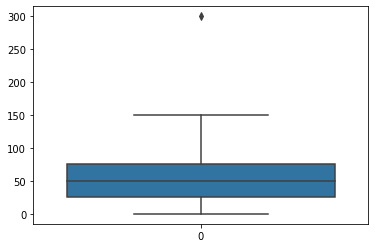

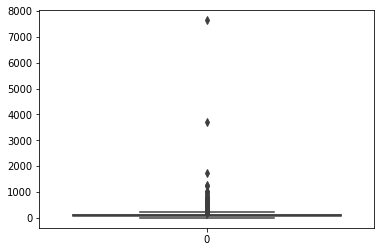

,length,mean,std,min,25%,50%,75%,max
0,8836,114.203957,122.295782,0.0,71.505,98.99,130.395,7639.21


In [ ]:
import seaborn as sns

def numerical_eda(data):
    sns.boxplot(data=data)
    plt.show()

def numerical_stat(data):
    return pd.DataFrame(data=[[len(data), data.mean(), data.std(), data.min(), np.percentile(data, 25), np.percentile(data, 50), np.percentile(data, 75), data.max()]],
                        columns = ['length', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])

print(len(df))
numerical_eda(np.concatenate([np.arange(100), [150, 300]]))
numerical_eda(df['building shifting total area'].values)
numerical_stat(df['building shifting total area'].values)


Index(['鋼筋混凝土造', '加強磚造', '', '見其他登記事項', '鋼骨鋼筋混凝土造', '磚造', '鋼骨混凝土造',
       '壁式預鑄鋼筋混凝土造', '木造', '土磚石混合造', '鋼筋混凝土加強磚造', '鋼造', '石造', '見使用執照', '土造'],
      dtype='object') 15


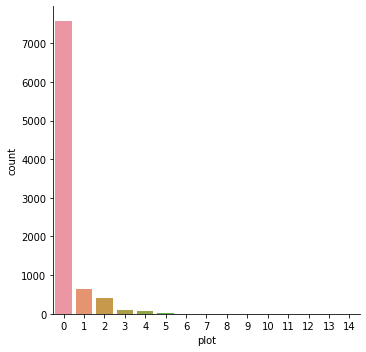

/usr/local/lib/python3.6/dist-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/usr/local/lib/python3.6/dist-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: divide by zero encountered in true_divide
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/usr/local/lib/python3.6/dist-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: invalid value encountered in multiply
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:180: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=endog)[0] for i in range(1, gridsize)]
/usr/local/lib/python3.6/dist-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: invalid va

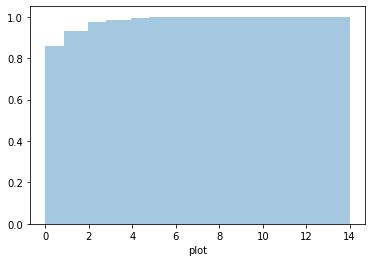

鋼筋混凝土造 7574
加強磚造 632
見其他登記事項 103
鋼骨鋼筋混凝土造 79
磚造 28
鋼骨混凝土造 5
壁式預鑄鋼筋混凝土造 4
木造 4
土磚石混合造 3
鋼筋混凝土加強磚造 2
鋼造 2
石造 1
見使用執照 1
土造 1


In [ ]:
def categorical_eda(df, col):
    idx = df[col].fillna('').value_counts().index
    print(idx, len(idx))
    idx_map = dict(zip(idx, np.arange(len(idx))))
    df['plot'] = df[col].fillna('').map(idx_map)
    sns.catplot(x='plot', kind='count', data=df)
    plt.show()

    kwargs = {'cumulative': True}
    sns.distplot(df['plot'], hist_kws=kwargs, kde_kws=kwargs)
    plt.show()
    return idx_map

categorical_eda(df, 'main building materials')
for value, count in df['main building materials'].value_counts().iteritems():
    print(value, count)


2012-07-01T00:00:00+00:00 2019-05-03T00:00:00+00:00


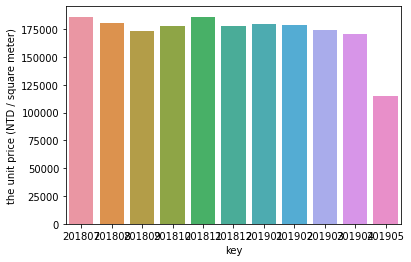

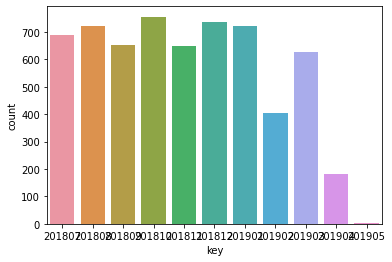

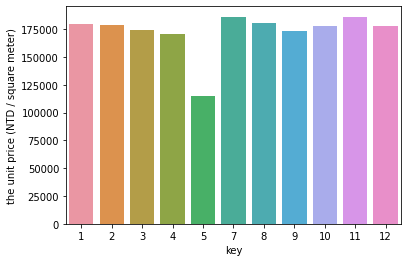

     the unit price (NTD / square meter)  count
key                                            
1                          179621.167822    721
2                          178395.336634    404
3                          174517.376997    626
4                          170866.182320    181
5                          115147.000000      2
7                          186157.202899    690
8                          180396.027663    723
9                          173356.712098    653
10                         178213.716798    756
11                         185807.515229    649
12                         178115.153324    737


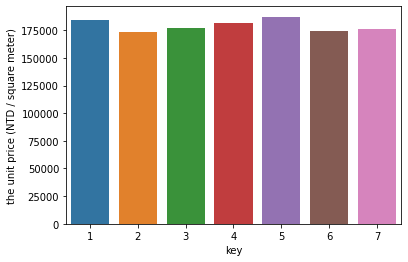

In [ ]:
def time_seris_eda(df, time_col, col):
    df['count'] = 1
    df['key'] = df[time_col].map(lambda x: x.year * 100 + x.month)
    dfg = df[['key', col]].groupby(by='key').mean()
    sns.barplot(x=dfg.index, y=dfg[col])
    plt.show()

    df['key'] = df[time_col].map(lambda x: x.year * 100 + x.month)
    dfg = df[['key', 'count']].groupby(by='key').sum()
    sns.barplot(x=dfg.index, y=dfg['count'])
    plt.show()

    df['key'] = df[time_col].map(lambda x: x.month)
    dfg = df[['key', col]].groupby(by='key').mean()
    sns.barplot(x=dfg.index, y=dfg[col])
    plt.show()

    dfg['count'] = df[['key', 'count']].groupby(by='key').sum()['count']
    print(dfg)

    df['key'] = df[time_col].map(lambda x: x.isoweekday())
    dfg = df[['key', col]].groupby(by='key').mean()
    sns.barplot(x=dfg.index, y=dfg[col])
    plt.show()

df['transaction_time'] = df['transaction year month and day'].map(lambda x: arrow.get(str(x + 19110000), 'YYYYMMDD'))
print(df['transaction_time'].min(), df['transaction_time'].max())
df = df.loc[df['transaction_time'] >= arrow.get('20180701', 'YYYYMMDD')]
time_seris_eda(df, 'transaction_time', 'the unit price (NTD / square meter)')

In [ ]:
# correlation with label
for col in df.select_dtypes(include=[np.number]).columns:
    if col in ('plot', 'key', 'count', label, 'non-metropolis land use'):
        continue
    index = df[col].notnull()
    dfi = df.loc[index]
    print(col, np.corrcoef(dfi[col].values, dfi[label].values)[0, 1])

# 注意：total price NTD 不能當作 feature

land shifting total area square meter 0.06976072656247799
transaction year month and day -0.01828635356526313
construction to complete the years 0.3166492204027731
building shifting total area 0.08335661541665858
Building present situation pattern - room -0.1777810136264017
building present situation pattern - hall -0.14140240722773917
building present situation pattern - health -0.07829518992746234
total price NTD 0.34115544566733613
berth shifting total area square meter 0.2034863445636443
the berth total price NTD 0.2323640662774167


# **使用 Google Map API 畫出台北市房價地圖**

1. 區間地址轉成點地址
1. 計算房價顏色
1. 地址轉經緯度
1. 計算每個經緯度的平均房價
1. 使用經緯度在地圖上加入 Marker
1. 加入自定義的圖片做顏色說明 (用 Marker 的方式加入地圖)

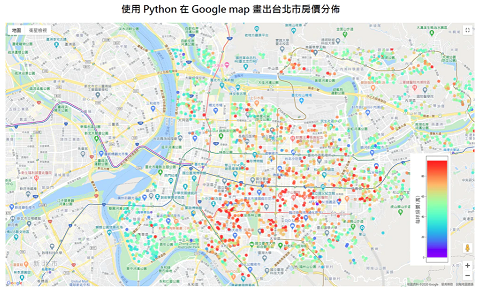

In [ ]:
# !pip install -U git+https://github.com/lintseju/gmplot

# 區間地址轉成點地址
pattern = re.compile('\d+~\d+')

def address_process(addr):
    matched = re.search(pattern, addr)
    if matched:
        val = matched.group(0).split('~')
        val = (int(val[0]) + int(val[1])) // 2
        addr = addr.replace(addr[matched.span(0)[0]:matched.span(0)[1]], str(val))
    return addr

df['address'] = df['land sector position building sector house number plate'].map(lambda x: address_process(x))
df['address'].head()

5989        臺北市大安區信義路三段73巷15號
5689      臺北市士林區中山北路七段190巷15號
5206         臺北市萬華區青年路168巷15號
2153    臺北市內湖區內湖路一段629巷27弄15號
4768           臺北市萬華區武成街4巷15號
Name: address, dtype: object

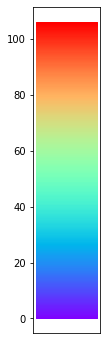

In [ ]:
def get_hex(flt):
    val = hex(int(np.clip(flt * 255, 0, 255)))[2:]
    while len(val) < 2:
        val = '0' + val
    return val

max_v = np.percentile(df['the unit price (NTD / square meter)'].values, 95)
min_v = df['the unit price (NTD / square meter)'].min()

scale = 0.6
plt.rcParams["figure.figsize"] = (2 * scale, 10 * scale)
plt.xticks([])
# fc-list :lang=zh-tw
# windows 字型路徑：
# fpath = '/usr/share/fonts/truetype/arphic/uming.ttc'
# import matplotlib.font_manager as fm
# font = fm.FontProperties(fname=fpath)
# font.set_weight('bold')
# plt.ylabel('每坪房價(萬)', fontproperties=font, fontsize=20)
y_list = np.linspace(0, max_v, 500)
for i in range(len(y_list) - 1):
    val = y_list[i] / max_v
    # 平方公尺 => 坪
    plt.fill_betweenx(y_list[i:i + 2] * 3.305 / 10000, [0, 0], [1, 1], color=cm.rainbow(val))
plt.savefig('bar.png', bbox_inches=transforms.Bbox.from_bounds(-0.7, 1 * scale, 2 * scale + 0.7, 8 * scale))
plt.show()

In [ ]:
# 地址轉經緯度
# 方法一：lat, lon = gmplot.GoogleMapPlotter.geocode(addr, apikey)
# 方法二：use data from:　https://github.com/zhengda/taiwan-address-data 下述

DIR_ADDR = 'taiwan-address-data/'

pattern_section = re.compile('\d+段')
pattern_lane = re.compile('\d+巷')
pattern_alley = re.compile('\d+弄')
pattern_number = re.compile('\d+號')

def get_area2id():
    area2id = dict()
    for file in glob.iglob(os.path.join(DIR_ADDR, 'area_*.csv')):
        df = pd.read_csv(file, index_col='name')
        for k, v in df.to_dict()['dgbas_id'].items():
            v = str(v)
            if k not in area2id:
                cid, tid, vid = '', '', ''
                if len(v) == 11:
                    vid = v
                    tid = v[:7]
                elif len(v) == 7:
                    tid = v
                else:
                    cid = v

                if tid != '':
                    if tid.startswith('10') or tid.startswith('09'):
                        cid = v[:5]
                    else:
                        cid = v[:2]

                if cid == '10003':
                    cid = '68'
                    if tid != '':
                        tid = '680' + tid[5:7] + '00'
                    if vid != '':
                        vid = tid + '-' + vid.split('-')[1]
                area2id[k] = (cid, tid, vid)
    return area2id


def get_cid2roads():
    df = pd.read_csv(os.path.join(DIR_ADDR, 'road.csv'), dtype={'county_id': str}).fillna('')
    cid2roads = dict()
    for row in df.itertuples():
        if row.county_id not in cid2roads:
            cid2roads[row.county_id] = set()
        cid2roads[row.county_id].add(row.road)
    return cid2roads


WORD_DICT = {
    '衞': '衛',
    '臺': '台',
    '巿': '市',
    '舘': '館',
    '羣': '群',
    '峯': '峰',
}


def get_loc(area2id, max_area_len, cid2roads, max_road_len, addr):
    for k, v in WORD_DICT.items():
        addr = addr.replace(k, v)
    addr = addr.replace('福建省', '')
    addr = addr.replace('台灣省', '')

    cid, tid, vid = None, None, None
    search_len = min(max_area_len, len(addr))
    while search_len > 0:
        if addr[:search_len] in area2id:
            cid, tid, vid = area2id[addr[:search_len]]
            addr = addr[search_len:]
            break
        search_len -= 1
    if cid is None or cid != '63':
        # logging.info('Location not found: %s', addr)
        return None, None

    roads = cid2roads[cid]
    search_len = min(max_road_len, len(addr))
    road = None
    while search_len > 0:
        if addr[:search_len] in roads:
            road = addr[:search_len]
            addr = addr[search_len:]
            break
        search_len -= 1
    if cid is None or road is None:
        # logging.info('Location not found: %s', addr)
        return None, None

    path = os.path.join(DIR_ADDR, 'roads/%s-%s.csv' % (cid, road))
    if not os.path.exists(path):
        return None, None
    df = pd.read_csv(os.path.join(DIR_ADDR, 'roads/%s-%s.csv' % (cid, road)))

    matched = re.search(pattern_section, addr)
    try:
        if matched:
            df = df.loc[df['SECTION'] == matched.group(0)]
        matched = re.search(pattern_lane, addr)
        if matched:
            df = df.loc[df['LANE'] == matched.group(0)]
        matched = re.search(pattern_alley, addr)
        if matched:
            df = df.loc[df['ALLEY'] == matched.group(0)]
        matched = re.search(pattern_number, addr)
        if matched:
            if len(df.loc[df['NUMBER'] == matched.group(0)]) > 0:
                df = df.loc[df['NUMBER'] == matched.group(0)]
        if len(df) == 0:
            return None, None
        x = df['X'].mean()
        y = df['Y'].mean()
        return x, y
    except:
        return None, None

area2id = get_area2id()
max_area_len = max(map(len, list(area2id.keys())))
cid2roads = get_cid2roads()
max_road_len = max(map(len, list(cid2roads.values()))) 

pattern = re.compile('\d+~\d+')

addr_dict = dict()
price_dict = dict()
df['price'] = df['the unit price (NTD / square meter)']
max_x, max_y = -np.inf, -np.inf
min_x, min_y = np.inf, np.inf
for row in df.itertuples():
    if row.address not in addr_dict:
        # 地址轉經緯度
        x, y = get_loc(area2id, max_area_len, cid2roads, max_road_len, row.address)
        addr_dict[row.address] = (x, y)
    else:
        x, y = addr_dict[row.address]
    if x is not None:
        # round 到小數點第四位避免浮點數太多種，計算平均會偏差
        x = round(x, 4)
        y = round(y, 4)
        max_x = max(max_x, x)
        max_y = max(max_y, y)
        min_x = min(min_x, x)
        min_y = min(min_y, y)
        if (x, y) not in price_dict:
            price_dict[(x, y)] = [0.0, 0]
        # 價格的總合
        price_dict[(x, y)][0] += row.price
        # 資料筆數
        price_dict[(x, y)][1] += 1

# 計算每個座標的平均價格
for (x, y), val in price_dict.items():
    price_dict[(x, y)] = val[0] / val[1]


In [ ]:
x_cen = (max_x + min_x) / 2
y_cen = (max_y + min_y) / 2
# 地圖的中心點，api key 可填可不填，不填會有浮水印
gmap = gmplot.GoogleMapPlotter(y_cen, x_cen, 12, apikey='')
# 加入房價顏色示意圖
gmap.add_icon_file('bar', 'bar.png')
# 這個經緯度是人工事先找出來的
gmap.icon(25.006414, 121.599962, 'bar')
i = 0
for (x, y), val in price_dict.items():
    # 找出對應的顏色
    val = min(val, max_v)
    val = (val - min_v) / (max_v - min_v)
    c = cm.rainbow(val)
    c = '#%s%s%s' % (get_hex(c[0]), get_hex(c[1]), get_hex(c[2]))
    # 在經緯度畫出剛剛算的顏色
    gmap.scatter([y], [x], c=c, size=50, marker=False, face_alpha=0.8)
# 存檔
gmap.draw("./google_map.html", language='zh_tw')


In [ ]:
# 從 google drvie 下載檔案到你的電腦
files.download('bar.png')
files.download('google_map.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

如何獲得 Google map API key？
https://developers.google.com/maps/documentation/javascript/get-api-key?hl=zh-tw

需要 **Maps JavaScript API** 及 **Geocoding API**